In [95]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure #plot size
import matplotlib.style #Setting the theme of your plots
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pprint import pprint
from sklearn.metrics import mean_squared_error as mse

In [96]:
data = pd.read_csv("train.csv")
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA & Preprocessing

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [98]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [99]:
#Null value treatment
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [100]:
# impute missing values in item weight by mean
data.Item_Weight.fillna(data.Item_Weight.mean(),inplace=True)
# impute outlet size in training data by mode
data.Outlet_Size.fillna(data.Outlet_Size.mode()[0],inplace=True)
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [101]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

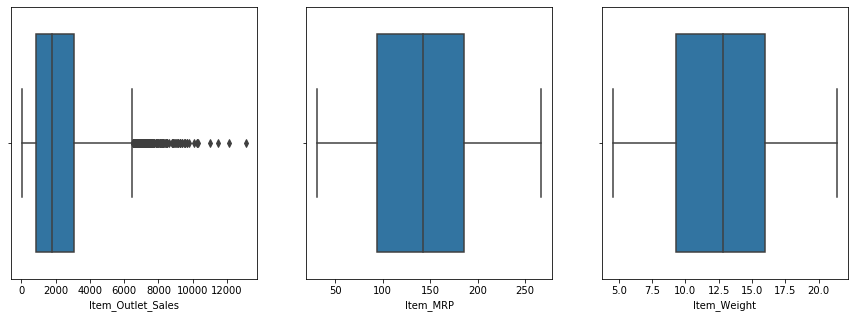

In [102]:
#Outlier Identification
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(data.Item_Outlet_Sales, ax = axs[0])
sns.boxplot(data.Item_MRP, ax = axs[1])
sns.boxplot(data.Item_Weight, ax = axs[2])

plt.tight_layout
plt.show()

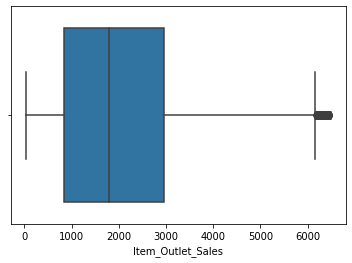

In [103]:
#Outlier imputation with median

#Outlier imputation with median
Q1 = data['Item_Outlet_Sales'].quantile(0.25)
Q3 = data['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3-Q1

median = float(data['Item_Outlet_Sales'].median())
data['Item_Outlet_Sales'] = np.where(~((data['Item_Outlet_Sales'] >= Q1 - 1.5*IQR) & (data['Item_Outlet_Sales'] <= Q3 + 1.5*IQR)),
                                    median, data['Item_Outlet_Sales'])
sns.boxplot(data['Item_Outlet_Sales'])


In [105]:
#Categorical columns
data1=data.drop('Item_Identifier',axis=1)
cat_cols=data1.select_dtypes(exclude=['int64', 'float64']).columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [111]:
#Data frame with all features for Random Forest and Boosting Algoithms, and Splitting -partition

new=data.drop('Item_Identifier',axis=1)

#Create dummy variables with 1 hot encoder
from sklearn.preprocessing import OneHotEncoder

all= pd.get_dummies(new)
X_all=all.drop('Item_Outlet_Sales',axis=1)
y_all =all['Item_Outlet_Sales']

from sklearn.model_selection import train_test_split
X_all_train,X_all_test,y_all_train,y_all_test = train_test_split(X_all,y_all, test_size=0.25, random_state=7)


In [9]:
#Chi-Square test for Categorical Columns
import scipy.stats


def Chi_Test(data):  # defining function
        chi_df=pd.DataFrame(columns=data.columns,index=data.columns)
        for idx in cat_cols:
            rec=[]
            for col2 in cat_cols:
                df=pd.crosstab(data1[idx],data1[col2])
                chi= scipy.stats.chi2_contingency(df)
                rec.append(chi[1])
            chi_df.loc[idx] = rec          
        
        
        dep_variables=[[]]  #list to store pairs of dependent catetgorical variables

        for i in chi_df.columns:
            val=0
            for j in chi_df.columns:
                if i!=j:
                    if chi_df[i][j]<0.5:   # Critical point 0.5 
                        for val in dep_variables:    
                                  if ([i,j] not in dep_variables) and (([j,i] not in dep_variables)):
                                     dep_variables.append([i,j])

        del dep_variables[0] #Delete empty list [ ]from this list
               
        return dep_variables   #return vategorical variables which have P value lessthano 0.5
         

In [10]:
dataset=data1[cat_cols]
chi_df=Chi_Test(dataset)
chi_df

[['Item_Fat_Content', 'Item_Type'],
 ['Item_Fat_Content', 'Outlet_Type'],
 ['Outlet_Identifier', 'Outlet_Size'],
 ['Outlet_Identifier', 'Outlet_Location_Type'],
 ['Outlet_Identifier', 'Outlet_Type'],
 ['Outlet_Size', 'Outlet_Location_Type'],
 ['Outlet_Size', 'Outlet_Type'],
 ['Outlet_Location_Type', 'Outlet_Type']]

Here this pairs are dependet on each other. So we have to remove 1 variable in each pair.


In [11]:
#Show remove this columns from data1
data2=data1.drop(['Item_Type','Outlet_Type','Outlet_Identifier','Outlet_Location_Type'],axis=1)
data2.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,249.8092,1999,Medium,3735.1380
1,5.92,Regular,0.019278,48.2692,2009,Medium,443.4228
2,17.50,Low Fat,0.016760,141.6180,1999,Medium,2097.2700
3,19.20,Regular,0.000000,182.0950,1998,Medium,732.3800
4,8.93,Low Fat,0.000000,53.8614,1987,High,994.7052


In [12]:
#Create dummy variables with 1 hot encoder
from sklearn.preprocessing import OneHotEncoder

data3 = pd.get_dummies(data2)
data3.shape

(8523, 13)

In [13]:
data3.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,9.30,0.016047,249.8092,1999,3735.1380,0,1,0,0,0,0,1,0
1,5.92,0.019278,48.2692,2009,443.4228,0,0,1,0,0,0,1,0
2,17.50,0.016760,141.6180,1999,2097.2700,0,1,0,0,0,0,1,0
3,19.20,0.000000,182.0950,1998,732.3800,0,0,1,0,0,0,1,0
4,8.93,0.000000,53.8614,1987,994.7052,0,1,0,0,0,1,0,0


In [17]:
#Correlation
cr=data3.corr(method='pearson')
corr_variables=[]

for i in cr.columns:
    for j in cr.columns:
        if i!=j:
            if cr[i][j]>0.9:
                corr_variables.append([i,j])
          
corr_variables

[]

There are no tight correlated indipendent variables

In [18]:
cr.Item_Outlet_Sales.sort_values()

Item_Visibility             -0.128625
Outlet_Size_Small           -0.098403
Outlet_Establishment_Year   -0.049135
Item_Fat_Content_reg        -0.015148
Item_Fat_Content_LF         -0.012389
Item_Fat_Content_Low Fat    -0.011993
Item_Fat_Content_low fat    -0.006326
Item_Weight                  0.011550
Item_Fat_Content_Regular     0.022618
Outlet_Size_High             0.024170
Outlet_Size_Medium           0.075154
Item_MRP                     0.567574
Item_Outlet_Sales            1.000000
Name: Item_Outlet_Sales, dtype: float64

There are almost all weekly correlated expect Item_MRP

In [19]:
#Data Partition
X=data3.drop(['Item_Outlet_Sales'],axis=1)
y=data3['Item_Outlet_Sales']

In [20]:
X.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,9.30,0.016047,249.8092,1999,0,1,0,0,0,0,1,0
1,5.92,0.019278,48.2692,2009,0,0,1,0,0,0,1,0
2,17.50,0.016760,141.6180,1999,0,1,0,0,0,0,1,0
3,19.20,0.000000,182.0950,1998,0,0,1,0,0,0,1,0
4,8.93,0.000000,53.8614,1987,0,1,0,0,0,1,0,0


In [21]:
#  Feature Scaling
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
norm_X = standard_scaler.fit_transform(X)
norm_X=pd.DataFrame(norm_X,columns=X.columns)
norm_X.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
0,-0.841872,-0.970732,1.747454,0.139541,-0.196224,0.821455,-0.716086,-0.115395,-0.117977,-0.350395,0.798807,-0.623893
1,-1.641706,-0.908111,-1.489023,1.334103,-0.196224,-1.217352,1.396480,-0.115395,-0.117977,-0.350395,0.798807,-0.623893
2,1.098554,-0.956917,0.010040,0.139541,-0.196224,0.821455,-0.716086,-0.115395,-0.117977,-0.350395,0.798807,-0.623893
3,1.500838,-1.281758,0.660050,0.020085,-0.196224,-1.217352,1.396480,-0.115395,-0.117977,-0.350395,0.798807,-0.623893
4,-0.929428,-1.281758,-1.399220,-1.293934,-0.196224,0.821455,-0.716086,-0.115395,-0.117977,2.853918,-1.251866,-0.623893


In [22]:
#Data Splitting 

In [23]:
#Training Data ,Test Data Split

#Data Splitting
X=norm_X.values
y=y.values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=7)

# Model Building

# Linear Regression

Regression Score is  0.35047490252535923
Linear Regression RMSE:1386.0880


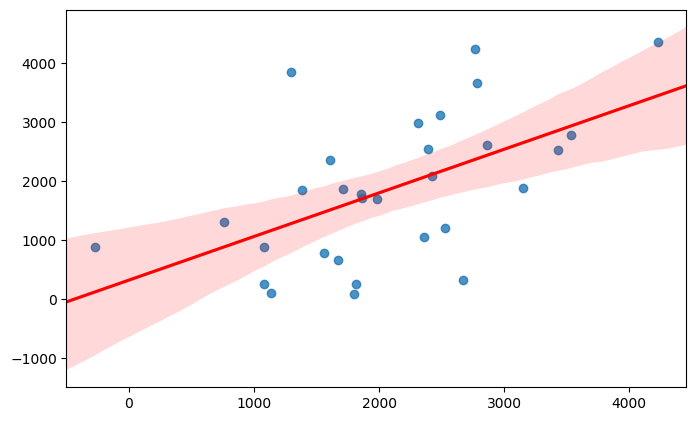

In [166]:
LR=LinearRegression()
LR.fit(X_train,y_train)

#Evalution for Test Data

y_pred_test=LR.predict(X_test)
print("Regression Score is ",LR.score(X_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_test[:30], line_kws={'color':'red'})

# Polynomial Regression

In [27]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

for i in range(1,5):
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(X_train)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y_train)
    sc1=pol_reg.score(X_poly,y_train)
    sc2=pol_reg.score(poly_reg.fit_transform(X_test),y_test)
    y_pred = pol_reg.predict(poly_reg.fit_transform(X_test))
    lin_mse=mse(y_pred,y_test)
    lin_rmse=np.sqrt(lin_mse)
    print(i,'th degree train data  score =',sc1, ' test data score=',sc2,'RMSE =',lin_rmse)

1 th degree train data  score = 0.35533448408045465  test data score= 0.34938407123137005 RMSE = 1387.2514521964729
2 th degree train data  score = 0.48298682305864316  test data score= 0.458454960917797 RMSE = 1265.639828254558
3 th degree train data  score = 0.5686413851566505  test data score= 0.5044360252361793 RMSE = 1210.7171827677964
4 th degree train data  score = 0.5970204237847492  test data score= -6181487089630.381 RMSE = 4276016038.6908097


Here 3 degree gives better result

In [28]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

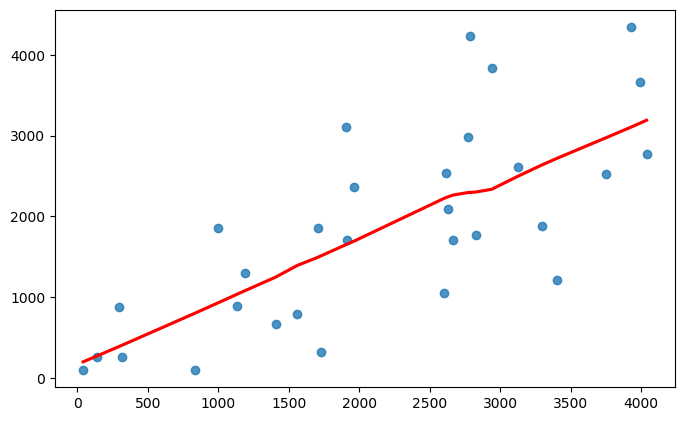

In [167]:
#Evalution for test data
y_pred_test = pol_reg.predict(poly_reg.fit_transform(X_test))
figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_test[:30],lowess=True, line_kws={'color':'red'})

It is also doesn't fit data properly. Lets go to the other models

# Desicion Tree

It is a tree based algorithm . No need about feature scaling

In [31]:
X1 = data3.drop(['Item_Outlet_Sales'],axis=1)
y1 = data3['Item_Outlet_Sales']

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1, test_size=0.25, random_state=7)

In [32]:
#Desision Tree Regressior

from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(random_state=7 ,max_depth=15)
DTR.fit(X1_train,y1_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=7, splitter='best')

Regression Score is  -0.6184996780205108
Linear Regression RMSE:2188.0092


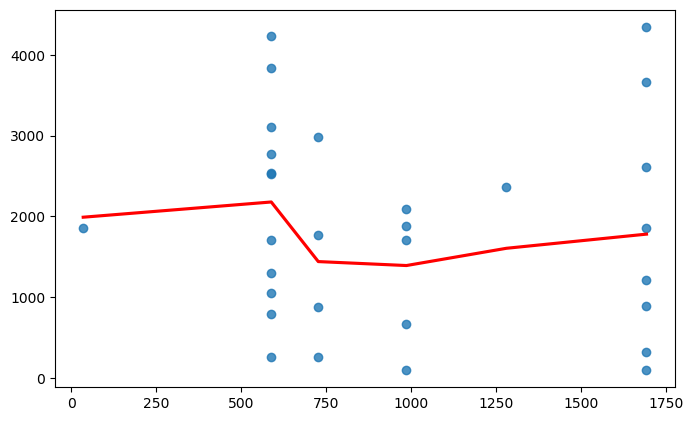

In [34]:
#Evalution for Test Data

y_pred_test=DTR.predict(X_test)
print("Regression Score is ",DTR.score(X_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_test[:30],lowess=True, line_kws={'color':'red'})

# SVM

In [35]:
from sklearn.svm import SVR

SV=SVR(kernel='poly',degree =12)
SV.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=12, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Regression Score is  -2.6519426733580507
Linear Regression RMSE:3286.6603


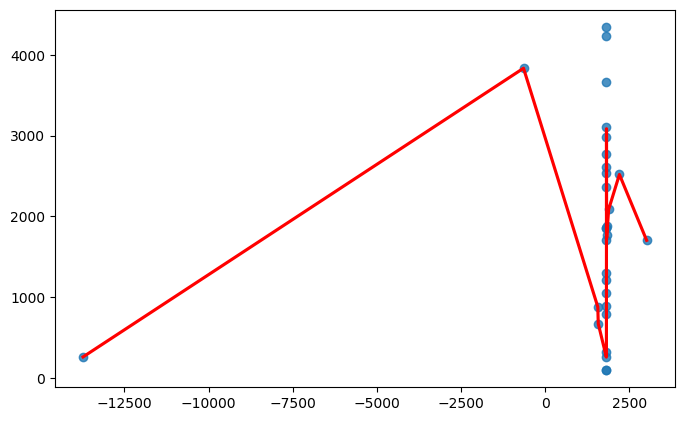

In [168]:
#Evalution for Taining Data

y_pred_test=SV.predict(X_test)
print("Regression Score is ",SV.score(X_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)
figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_test[:30],lowess=True, line_kws={'color':'red'})

It is not good model

# KNN

In [169]:
from sklearn.neighbors import KNeighborsRegressor

i=3

while i<=21:
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    print('Train Data score with neighbours k=',i,':  ',KNN.score(X_train,y_train),
         'Test Data score with neighbours k=',i,':  ',KNN.score(X_test,y_test))
    i+=1

Train Data score with neighbours k= 3 :   0.7091752809811901 Test Data score with neighbours k= 3 :   0.36102283312867695
Train Data score with neighbours k= 4 :   0.670345331945476 Test Data score with neighbours k= 4 :   0.39676127970081265
Train Data score with neighbours k= 5 :   0.643288715794848 Test Data score with neighbours k= 5 :   0.4189677699186472
Train Data score with neighbours k= 6 :   0.6273784146679566 Test Data score with neighbours k= 6 :   0.44362683513223056
Train Data score with neighbours k= 7 :   0.6160414221997919 Test Data score with neighbours k= 7 :   0.44786442356267997
Train Data score with neighbours k= 8 :   0.6063688627802319 Test Data score with neighbours k= 8 :   0.4623905116446666
Train Data score with neighbours k= 9 :   0.5969185771879323 Test Data score with neighbours k= 9 :   0.47022327804455466
Train Data score with neighbours k= 10 :   0.5929141407274603 Test Data score with neighbours k= 10 :   0.4750839891493629
Train Data score with neigh

Here K=11 gives best result and which compramises both

# Random Forest

In [112]:
from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(n_estimators=300, random_state=1, bootstrap=True,max_depth =10)
rfc.fit(X_all_train,y_all_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

Regression Score is  0.512572540852029
Linear Regression RMSE:1207.1381


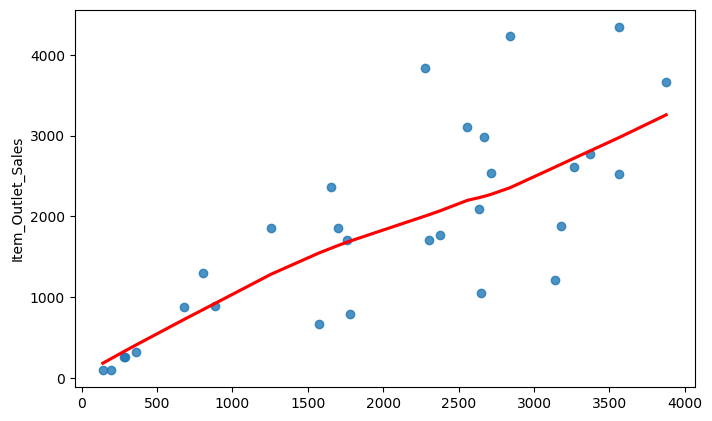

In [170]:
#Evalution for Test Data

y_pred_test=rfc.predict(X_all_test)
print("Regression Score is ",rfc.score(X_all_test,y_all_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_all_test[:30],lowess=True, line_kws={'color':'red'})

In [117]:
# Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(50,400,100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num =5 )]
# max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf
              'bootstrap' : bootstrap
             }

pprint(grid_param)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr =RandomForestRegressor()

{'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50, 150, 250, 350]}


In [118]:
from sklearn.model_selection import GridSearchCV

gd_sr = GridSearchCV(estimator=rfr,
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_all_train, y_all_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_
print(best_result)


{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}
0.5548053406624736


In [172]:
from sklearn.ensemble import RandomForestRegressor

rfc_best=RandomForestRegressor(n_estimators=150, bootstrap=True, max_depth=15 ,max_features='sqrt')
rfc_best.fit(X_all_train,y_all_train)

y_pred_test=rfc_best.predict(X_all_test)
print("Regression Score is ",rfc_best.score(X_all_test,y_all_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

Regression Score is  0.49983220386187005
Linear Regression RMSE:1234.4396


Now test for best variables

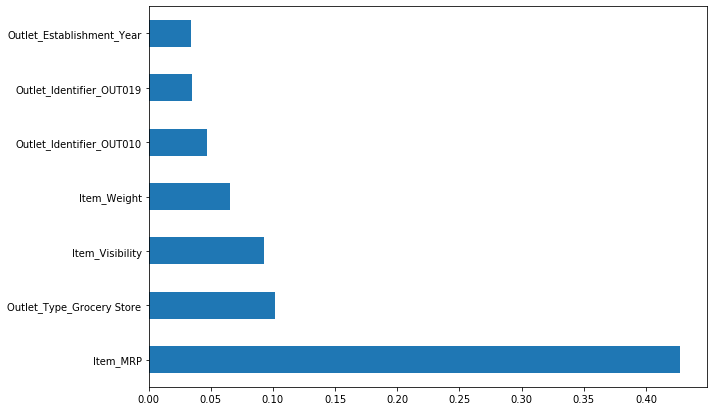

In [142]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rfc_best.feature_importances_, index = X_all_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

Now Check accuracy with this parameters

In [149]:
X_best = X_all[feat_importances.nlargest(7).index]

X_best_train,X_best_test,y_train,y_test = train_test_split(X_best,y, test_size=0.25, random_state=7)

In [159]:
rfc_opt=RandomForestRegressor(n_estimators=300, bootstrap=True, max_depth=15)
rfc_opt.fit(X_best_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [161]:
y_pred_test=rfc_best.predict(X_all_test)
print("Regression Score is ",rfc_opt.score(X_best_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)



Regression Score is  0.5460754842975001
Linear Regression RMSE:1232.3767


This Random Forest Model gives better accuracy and ,low RMSE value for both train and test data.

# Gradient Boost

In [90]:
from sklearn.ensemble import GradientBoostingRegressor
GBC=GradientBoostingRegressor()
GBC.fit(X1_train,y1_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Regression Score is  0.571206540944369
Linear Regression RMSE:1126.2036


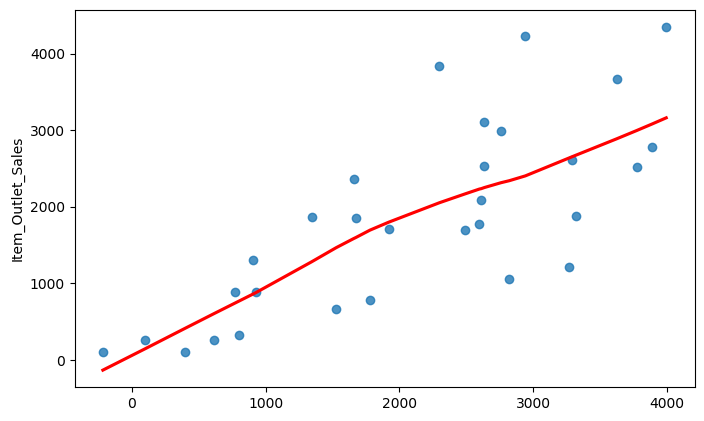

In [175]:
#Evalution for Test Data

y_pred_test=GBC.predict(X1_test)
print("Regression Score is ",GBC.score(X1_test,y1_test))

lin_mse=mse(y_pred_test,y1_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y1_test[:30],lowess=True, line_kws={'color':'red'})

In [173]:
# Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(50,400,100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num =5 )]
# max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree



# Create the random grid
grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf
              #'bootstrap' : bootstrap
             }

pprint(grid_param)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
GB =GradientBoostingRegressor()

{'max_depth': [3, 7, 11, 15, 20],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50, 150, 250, 350]}


In [174]:
from sklearn.model_selection import GridSearchCV

gd_sr = GridSearchCV(estimator=GB,
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_all_train, y_all_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_
print(best_result)

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 50}
0.5540859276252024


Regression Score is  0.52525921249636
Linear Regression RMSE:1193.2392


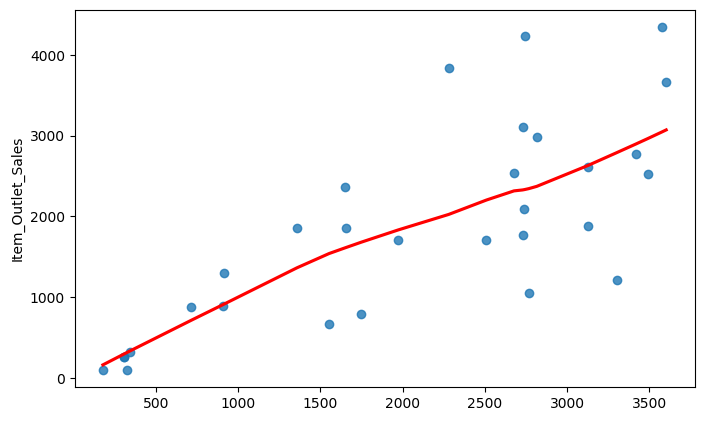

In [176]:
#Evalution for Test Data

y_pred_test=gd_sr.predict(X_all_test)
print("Regression Score is ",gd_sr.score(X_all_test,y_all_test))

lin_mse=mse(y_pred_test,y1_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

figure(num=None, figsize=(8, 5), dpi=100)
sns.regplot(y_pred_test[:30], y_all_test[:30],lowess=True, line_kws={'color':'red'})

Lets check best features

In [189]:
from sklearn.ensemble import GradientBoostingRegressor
GBC_bst=GradientBoostingRegressor(n_estimators=50 , max_depth=3)
GBC_bst.fit(X_all_train,y_all_train)
y_pred_test=GBC_bst.predict(X_all_test)
print("Regression Score is ",GBC_bst.score(X_all_test,y_all_test))

lin_mse=mse(y_pred_test,y1_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

Regression Score is  0.52525921249636
Linear Regression RMSE:1193.2392


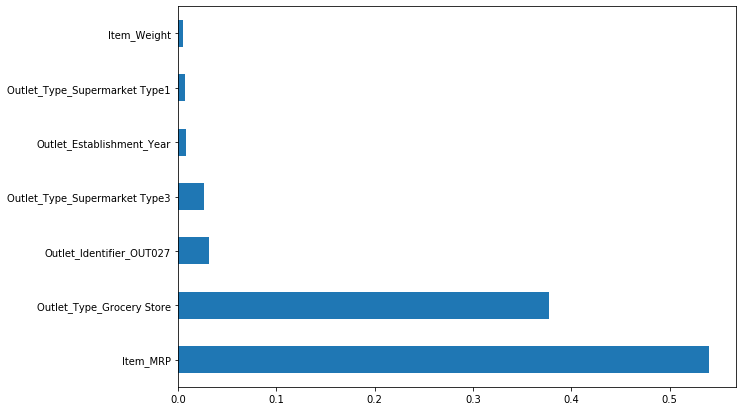

In [191]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(GBC_bst.feature_importances_, index = X_all_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

Lets try with these features

In [195]:
X_bst = X_all[feat_importances.nlargest(7).index]

X_bst_train,X_bst_test,y_train,y_test = train_test_split(X_bst,y, test_size=0.25, random_state=7)

GBC_bst=GradientBoostingRegressor(n_estimators=50 , max_depth=3)
GBC_bst.fit(X_bst_train,y_train)
y_pred_test=GBC_bst.predict(X_bst_test)
print("Regression Score is ",GBC_bst.score(X_bst_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)


Regression Score is  0.575989430816175
Linear Regression RMSE:1119.9050


# AdaBoost Regressor

In [214]:
from sklearn.ensemble import AdaBoostRegressor
ABR= AdaBoostRegressor()
ABR.fit(X_all_train,y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [215]:
y_pred_test=ABR.predict(X_all_test)
print("Regression Score is ",ABR.score(X_all_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)


Regression Score is  0.4711710097509435
Linear Regression RMSE:1250.6923


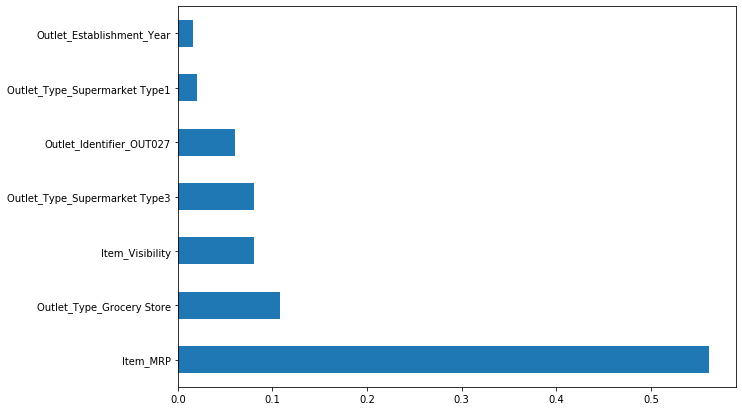

In [223]:
#Feature importance
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(ABR.feature_importances_, index = X_all_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

In [224]:
X_bst = X_all[feat_importances.nlargest(7).index]

X_bst_train,X_bst_test,y_train,y_test = train_test_split(X_bst,y, test_size=0.25, random_state=7)

ABR= AdaBoostRegressor()
ABR.fit(X_bst_train,y_train)
y_pred_test=ABR.predict(X_bst_test)
print("Regression Score is ",ABR.score(X_bst_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)


Regression Score is  0.4852954290259283
Linear Regression RMSE:1233.8770


# XGBoost

In [313]:
from xgboost import XGBRegressor

xgb= XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 150)
xgb.fit(X_all_train,y_all_train)

C:\Users\reshw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:55:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [314]:
y_pred_test=xgb.predict(X_all_test)
print("Regression Score is ",xgb.score(X_all_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

Regression Score is  0.5103330054581342
Linear Regression RMSE:1203.4921


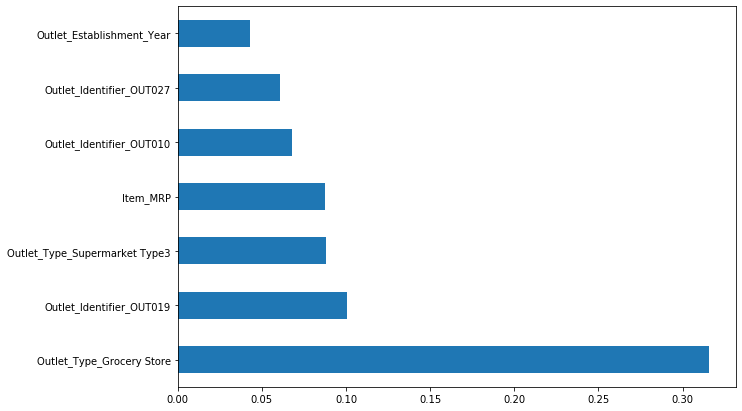

In [315]:
#Feature importance
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(xgb.feature_importances_, index = X_all_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

Now check with these features

In [316]:
X_bst = X_all[feat_importances.nlargest(7).index]
X_bst_train,X_bst_test,y_train,y_test = train_test_split(X_bst,y, test_size=0.25, random_state=7)

xgb= XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 150)


xgb.fit(X_bst_train,y_train)

y_pred_test=xgb.predict(X_bst_test)
print("Regression Score is ",xgb.score(X_bst_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)


[16:56:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Regression Score is  0.5749384014146934
Linear Regression RMSE:1121.2921


# Stacking Regressor

In [260]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


estimators = [
               ('lr', RidgeCV()),
               ('svr', LinearSVR(random_state=42))
             ]
reg = StackingRegressor(
                        estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=300,
                                                              random_state=42)
                        )

reg.fit(X_all_train, y_all_train)

y_pred_test=reg.predict(X_all_test)
print("Regression Score is ",reg.score(X_all_test,y_all_test))


lin_mse=mse(y_pred_test,y_all_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Regression Score is  0.3956157896216357
Linear Regression RMSE:1140.3381


# Voting Regressior

In [265]:
from sklearn.ensemble import VotingRegressor

estimators = [
               ('lr', LinearRegression()),
               ('svr', LinearSVR(random_state=42)),
               ('rf' ,RandomForestRegressor(n_estimators=300, random_state=42))
             ]
reg = VotingRegressor(
                        estimators=estimators
                                                )
reg.fit(X_all_train, y_all_train)

y_pred_test=reg.predict(X_all_test)
print("Regression Score is ",reg.score(X_all_test,y_all_test))


lin_mse=mse(y_pred_test,y_all_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

C:\Users\reshw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Regression Score is  0.47672779892008854
Linear Regression RMSE:1061.0624


# Bagging Regressor

In [244]:
from sklearn.ensemble import BaggingRegressor
BR=BaggingRegressor(n_estimators=300 ,random_state=1)
BR.fit(X_all_train, y_all_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=300,
                 n_jobs=None, oob_score=False, random_state=1, verbose=0,
                 warm_start=False)

In [245]:
y_pred_test=BR.predict(X_all_test)
print("Regression Score is ",BR.score(X_all_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

Regression Score is  0.47876524728784076
Linear Regression RMSE:1241.6795


# ExtraTreesRegressor

In [251]:
from sklearn.ensemble import ExtraTreesRegressor

ETR =ExtraTreesRegressor(bootstrap= True, n_estimators=300)
ETR.fit(X_all_train,y_all_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=300, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [252]:
y_pred_test=ETR.predict(X_all_test)
print("Regression Score is ",ETR.score(X_all_test,y_test))

lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)

Regression Score is  0.4855819159772391
Linear Regression RMSE:1233.5335


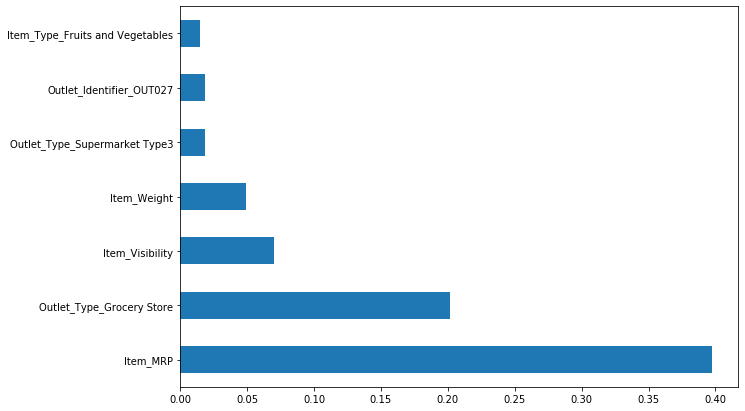

In [253]:
#Feature importance
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(ETR.feature_importances_, index = X_all_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

In [254]:
X_bst = X_all[feat_importances.nlargest(7).index]

X_bst_train,X_bst_test,y_train,y_test = train_test_split(X_bst,y, test_size=0.25, random_state=7)

ETR =ExtraTreesRegressor(bootstrap= True, n_estimators=300)
ETR.fit(X_bst_train,y_train)
y_pred_test=ETR.predict(X_bst_test)
print("Regression Score is ",ETR.score(X_bst_test,y_test))


lin_mse=mse(y_pred_test,y_test)
lin_rmse=np.sqrt(lin_mse)
print('Linear Regression RMSE:%.4f' %lin_rmse)


Regression Score is  0.5144866907244336
Linear Regression RMSE:1198.3769


Gradient boosting and Xgboost models give beeter accuracy for test data with limited features. So these are the final models

So lets save the XGbooster model and best features

In [325]:
#So i have to save model
from sklearn.externals import joblib
joblib.dump(xgb ,"xgb_bigmart_sales.pkl")  #Trained Model
joblib.dump(X_bst.columns,'bst_cols.pkl')  #Best features

['bst_cols.pkl']

Now lets load the test data for predictions

In [308]:
test = pd.read_csv("Test.csv")
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Now load the saved Model

In [326]:
#Load Saved Model and best features
bsf = joblib.load("xgb_bigmart_sales.pkl")
cols = joblib.load("bst_cols.pkl")
cols

[17:13:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Index(['Outlet_Type_Grocery Store', 'Outlet_Identifier_OUT019',
       'Outlet_Type_Supermarket Type3', 'Item_MRP', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT027', 'Outlet_Establishment_Year'],
      dtype='object')

Now encode the test data

In [328]:
#Create dummy variables with 1 hot encoder
from sklearn.preprocessing import OneHotEncoder
test_dummy = pd.get_dummies(test)
test_dummy.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,20.750,0.007565,107.8622,1999,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,8.300,0.038428,87.3198,2007,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,14.600,0.099575,241.7538,1998,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,7.315,0.015388,155.0340,2007,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,NaN,0.118599,234.2300,1985,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [329]:
#Now only select thoe features are important
new =test_dummy[cols]
new.head()

,Outlet_Type_Grocery Store,Outlet_Identifier_OUT019,Outlet_Type_Supermarket Type3,Item_MRP,Outlet_Identifier_OUT010,Outlet_Identifier_OUT027,Outlet_Establishment_Year
0,0,0,0,107.8622,0,0,1999
1,0,0,0,87.3198,0,0,2007
2,1,0,0,241.7538,1,0,1998
3,0,0,0,155.0340,0,0,2007
4,0,0,1,234.2300,0,1,1985


Now predict thesales with loaded model

In [331]:
test['Predicted Sales']= bsf.predict(new)
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Predicted Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1712.671875
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1444.291504
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,937.393250
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,2625.529785
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,5767.367188
